# Self-Reflecting Agents with Loops

**Self-Reflection**:

* a mechanism for self-assessment and correction
* refining outputs and providing more reliable and accurate information

In this Lesson:
* extract entities from the text
* reflect on extracted entities
* loop until done (or a max limit of looping is reached)

Other Use Case:
* extract data in JSON format adhering to the schema
* if validation fails, loop back for correction

### Preliminaries


Since we will use the `OpenAIGenerator` component, we need to make the correspondig API key accessible via environment.

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### Create the custom `EntitiesValidator` Component

- its `run()` method is expecting _replies_ coming from an LLM
- if the replies contain the word "done" we're going to output entities
- otherwise we will print out the entities that the LLM is still reflecting on (to see and visualize the loops), but also the output called "entities_to_validate"


In [2]:
from typing import List
from haystack import component
from colorama import Fore

@component
class EntitiesValidator:

    @component.output_types(entities_to_validate=str, entities=str)
    def run(self, replies: List[str]):
        if 'DONE' in replies[0]:
            return {"entities":replies[0].replace('DONE', '')}
        else:
            print(Fore.RED + "Reflecting on entities\n", replies[0])
            return {"entities_to_validate": replies[0]}

In [3]:
entities_validator = EntitiesValidator()
entities_validator.run(replies=["{'name': 'Andreas'}"])

Reflecting on entities
 {'name': 'Andreas'}


{'entities_to_validate': "{'name': 'Andreas'}"}

In [4]:
entities_validator = EntitiesValidator()
entities_validator.run(replies=["DONE {'name': 'Andreas'}"])

{'entities': " {'name': 'Andreas'}"}

### Create a Prompt Template

In [7]:
template = """"
{% if entities_to_validate %}
    Here was the text you were provided:
    {{ text }}
    Here are the entities you previously extracted: 
    {{ entities_to_validate[0] }}
    Are these the correct entities? 
    Things to check for:
    - Entity categories should exactly be "Person", "Location" and "Date"
    - There should be no extra categories
    - There should be no duplicate entities
    - If there are no appropriate entities for a category, the category should have an empty list
    If you are done say 'DONE' and return your new entities in the next line
    If not, simply return the best entities you can come up with.
    Entities:
{% else %}
    Extract entities from the following text
    Text: {{ text }} 
    The entities should be presented as key-value pairs in a JSON object.
    Example: 
    {
        "Person": ["value1", "value2"], 
        "Location": ["value3", "value4"],
        "Date": ["value5", "value6"]
    }
    If there are no possibilities for a particular category, return an empty list for this
    category
    Entities:
{% endif %}
"""

### Create a Self-Reflecting Agent

In [10]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.generators import OpenAIGenerator

prompt_template = PromptBuilder(template=template)
llm = OpenAIGenerator()
entities_validator = EntitiesValidator()

self_reflecting_agent = Pipeline(max_loops_allowed=10)

self_reflecting_agent.add_component("prompt_builder", prompt_template)
self_reflecting_agent.add_component("entities_validator", entities_validator)
self_reflecting_agent.add_component("llm", llm)

self_reflecting_agent.connect("prompt_builder.prompt", "llm.prompt")
self_reflecting_agent.connect("llm.replies", "entities_validator.replies")
self_reflecting_agent.connect("entities_validator.entities_to_validate", "prompt_builder.entities_to_validate")

🚅 Components
  - prompt_builder: PromptBuilder
  - entities_validator: EntitiesValidator
  - llm: OpenAIGenerator
🛤️ Connections
  - prompt_builder.prompt -> llm.prompt (str)
  - entities_validator.entities_to_validate -> prompt_builder.entities_to_validate (str)
  - llm.replies -> entities_validator.replies (List[str])

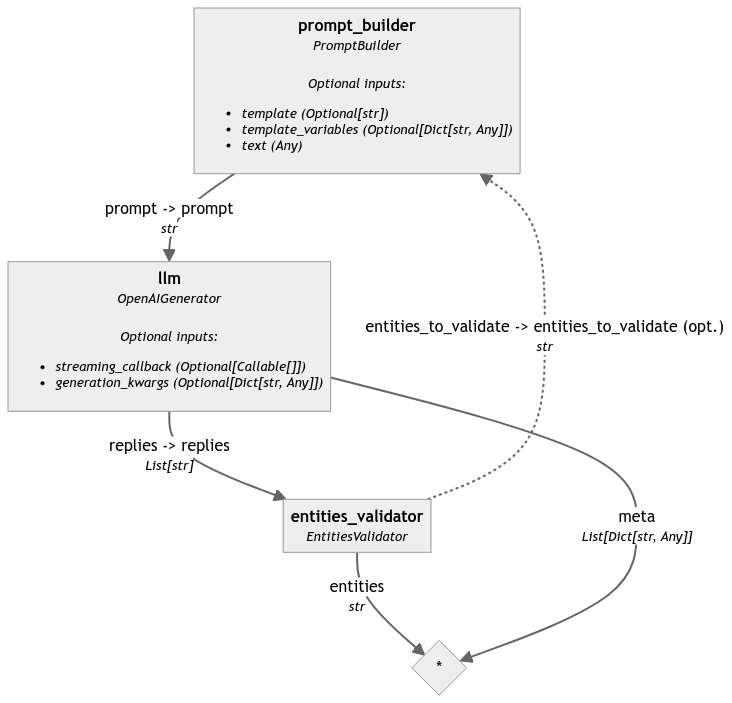

In [11]:
self_reflecting_agent.show()

In [17]:
text = """
Istanbul is the largest city in Turkey, straddling the Bosporus Strait, 
the boundary between Europe and Asia. It is considered the country's economic, 
cultural and historic capital. The city has a population of over 15 million residents, 
comprising 19% of the population of Turkey,[4] and is the most populous city in Europe 
and the world's fifteenth-largest city."""

result = self_reflecting_agent.run({"prompt_builder": {"text": text}})
print(Fore.GREEN + result['entities_validator']['entities'])

Reflecting on entities
 {
        "Location": ["Istanbul", "Turkey", "Bosporus Strait", "Europe", "Asia", "Europe"],
        "Population": ["15 million"],
        "Percentage": ["19%"],
        "City": ["Istanbul"]
    }
{
    "Person": [],
    "Location": [
        "Istanbul",
        "Turkey",
        "Bosporus Strait",
        "Europe",
        "Asia"
    ],
    "Date": []
}





In [14]:
text = """
Stefano: Hey all, let's start the all hands for June 6th 2024
Geoff: Thanks, I'll kick it off with a request. Could we please add persistent memory to the Chroma document store.
Stefano: Easy enough, I can add that to the feature requests. What else?
Julain: There's a bug, some BM25 algorithms return negative scores and we filter them out from the results by default.
Instead, we should probably check which algorithm is being used and keep results with negative scores accordingly.
Esmail: Before we end this call, we should add a new Generator component for LlamaCpp in the next release.
Tuana: Thanks all, I think we're done here, we can create some issues in GitHub about these."""

result = self_reflecting_agent.run({"prompt_builder": {"text": text}})
print(Fore.GREEN + result['entities_validator']['entities'])

Reflecting on entities
 {
    "Person": ["Stefano", "Geoff", "Julain", "Esmail", "Tuana"],
    "Date": ["June 6th 2024"],
    "Technology": ["Chroma document store", "BM25 algorithms", "LlamaCpp"],
    "Platform": ["GitHub"]
}
Reflecting on entities
 {
    "Person": [
        "Stefano",
        "Geoff",
        "Julain",
        "Esmail",
        "Tuana"
    ],
    "Location": [],
    "Date": [
        "June 6th 2024"
    ]
}
{
    "Person": [
        "Stefano",
        "Geoff",
        "Julian",
        "Esmail",
        "Tuana"
    ],
    "Location": [],
    "Date": [
        "June 6th 2024"
    ]
}

